In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import BaseCrossValidator
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor, \
    GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

from scipy.stats import spearmanr

In [3]:
dataset_path = '../data/model_data.h5'

# Load Data

In [4]:
data = pd.read_hdf(dataset_path, 'no_dummies')

In [5]:
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)
data

,Close,Volume,Open,High,Low,Consumption in mcf,Storage in mcf,US Gross Withdrawal in mcf,Other Gross Withdrawal in mcf,RSI,...,return_21d,return_42d,return_63d,target_1d,target_5d,target_10d,target_21d,year,month,weekday
Date,,,,,,,,,,,,,,,,,,,,,
2012-04-09,2.107,108772.0,2.103,2.117,2.065,1953071.0,2478.0,2417498.0,93400.0,34.901425,...,-0.003584,-0.003797,-0.005916,-0.036070,-0.015267,-0.006449,0.007501,2012,4,0
2012-04-10,2.031,120126.0,2.111,2.125,2.025,1953071.0,2478.0,2417498.0,93400.0,30.556017,...,-0.006397,-0.004436,-0.006230,-0.023634,-0.008005,0.001807,0.009692,2012,4,1
2012-04-12,1.983,188668.0,1.976,2.068,1.972,1953071.0,2478.0,2417498.0,93400.0,28.170441,...,-0.006395,-0.005282,-0.006237,-0.001009,-0.007785,0.002641,0.011266,2012,4,3
2012-04-13,1.981,111947.0,1.982,1.999,1.959,1953071.0,2503.0,2417498.0,93400.0,28.072097,...,-0.007064,-0.005306,-0.005330,0.017668,-0.005512,0.009896,0.009795,2012,4,4
2012-04-16,2.016,115321.0,1.986,2.030,1.977,1953071.0,2503.0,2417498.0,93400.0,32.512260,...,-0.005926,-0.004447,-0.004609,-0.032242,-0.000894,0.012604,0.010299,2012,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-24,3.896,54557.0,3.929,3.970,3.884,2218011.0,2851.0,3396062.0,32500.0,50.393336,...,-0.002451,0.003121,0.004626,0.000257,0.023556,0.023485,0.011719,2021,8,1
2021-08-25,3.897,37979.0,3.900,3.991,3.858,2218011.0,2851.0,3396062.0,32500.0,50.456830,...,-0.000895,0.002589,0.004246,0.073646,0.034399,0.025870,0.013270,2021,8,2
2021-08-26,4.184,64362.0,3.917,4.217,3.896,2218011.0,2851.0,3396062.0,32500.0,64.500602,...,0.001622,0.003632,0.005519,0.044455,0.020949,0.016707,0.014884,2021,8,3


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2351 entries, 2012-04-09 to 2021-08-30
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Close                          2351 non-null   float64
 1   Volume                         2351 non-null   float64
 2   Open                           2351 non-null   float64
 3   High                           2351 non-null   float64
 4   Low                            2351 non-null   float64
 5   Consumption in mcf             2351 non-null   float64
 6   Storage in mcf                 2351 non-null   float64
 7   US Gross Withdrawal in mcf     2351 non-null   float64
 8   Other Gross Withdrawal in mcf  2351 non-null   float64
 9   RSI                            2351 non-null   float64
 10  ATR                            2351 non-null   float64
 11  MACD                           2351 non-null   float64
 12  return_1d                     

In [7]:
def get_X_y(data: pd.DataFrame):
    columns_to_drop = ['Open', 'Close', 'Low', 'High', 'Volume']
    y = data.filter(like='target')
    X = data.drop(columns_to_drop, axis=1)
    X = X.drop(y.columns, axis=1)
    return X, y

In [8]:
X, y = get_X_y(data)

In [9]:
X, X_test, y, y_test = X.loc['2012':'2019'], X.loc['2019':'2021'], y.loc['2012':'2019'], y.loc['2019':'2021']

In [10]:
f'Train lenght: {len(X)}', f'Test length: {len(X_test)}'

('Train lenght: 1932', 'Test length: 671')

In [11]:
X_test

,Consumption in mcf,Storage in mcf,US Gross Withdrawal in mcf,Other Gross Withdrawal in mcf,RSI,ATR,MACD,return_1d,return_5d,return_10d,return_21d,return_42d,return_63d,year,month,weekday
Date,,,,,,,,,,,,,,,,
2019-01-02,3409295.0,2705.0,3384552.0,40363.0,33.538191,0.299760,-0.233675,0.006122,-0.031256,-0.017467,-0.020928,-0.002319,-0.001078,2019,1,2
2019-01-03,3409295.0,2705.0,3384552.0,40363.0,33.358741,0.287848,-0.258615,-0.004395,-0.036298,-0.026137,-0.018285,-0.002248,-0.001465,2019,1,3
2019-01-04,3409295.0,2614.0,3384552.0,40363.0,36.160111,0.278359,-0.267889,0.033616,-0.035236,-0.020013,-0.017993,-0.001805,-0.000619,2019,1,4
2019-01-07,3409295.0,2614.0,3384552.0,40363.0,34.578907,0.268048,-0.279667,-0.032852,-0.022750,-0.019451,-0.019680,-0.004560,-0.001038,2019,1,0
2019-01-08,3409295.0,2614.0,3384552.0,40363.0,35.279894,0.256687,-0.284057,0.007812,0.001830,-0.024851,-0.017807,-0.004296,-0.001528,2019,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-24,2218011.0,2851.0,3396062.0,32500.0,50.393336,0.132758,0.022960,-0.012421,0.003057,-0.004823,-0.002451,0.003121,0.004626,2021,8,1
2021-08-25,2218011.0,2851.0,3396062.0,32500.0,50.456830,0.132775,0.019566,0.000257,0.002326,-0.004065,-0.000895,0.002589,0.004246,2021,8,2
2021-08-26,2218011.0,2851.0,3396062.0,32500.0,64.500602,0.146220,0.038202,0.073646,0.017838,0.006206,0.001622,0.003632,0.005519,2021,8,3


In [12]:

class MultipleTimeSeriesCV(BaseCrossValidator):
    """Generates tuples of train_idx, test_idx pairs"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('Date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['Date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.Date > days[train_start])
                              & (dates.Date <= days[train_end])].index
            test_idx = dates[(dates.Date > days[test_start])
                             & (dates.Date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

In [13]:
n_splits = 15
train_period_length = 300
test_period_length = 100
lookaheads = [1, 5, 10, 21]

In [14]:
# Utilities functions

def display_score(scores):
    print('scores: ',scores)
    print('mean: ', scores.mean())
    print('standard deviation: ', scores.std())


def rank_correl(y, y_pred):
    return spearmanr(y, y_pred, axis=None)[0]

ic = make_scorer(rank_correl)


def get_cross_val_score(model, X, y, score_fun, cv, n_jobs=-1):
    cv_score = cross_val_score(estimator=model,
                           X=X,
                           y=y,
                           scoring=score_fun,
                           cv=cv,
                           n_jobs=n_jobs,
                           verbose=1)
    display_score(cv_score)

# Decision Tree Regressor

In [15]:
dt_reg = DecisionTreeRegressor(max_depth=None,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               max_features='auto')


In [16]:
for lookahead in lookaheads:
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)
    print(f'lookhead: {lookahead}')
    get_cross_val_score(dt_reg, X, y, ic, cv)
    print('\n')

lookhead: 1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.15238653  0.14018671  0.2153185  -0.13843069  0.04481708  0.05169326
  0.07256377  0.05329699 -0.03980304  0.06520921  0.1060184   0.12724088
 -0.04083035 -0.00593867  0.23649121]
mean:  0.04902978120466369
standard deviation:  0.108327977952881


lookhead: 5


[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.17630375  0.05693546  0.16319401 -0.08308428  0.06288638  0.15555443
  0.14100109  0.15499871 -0.07769656  0.1400585  -0.07494907 -0.04168497
  0.10923858  0.0066268   0.01791114]
mean:  0.03697909878269446
standard deviation:  0.10478926399559094


lookhead: 10
scores:  [-0.19970681  0.04470534  0.18765719 -0.10915018  0.0038961  -0.03335007
  0.07076656  0.23073034  0.0679473   0.11033365  0.0786758  -0.12377094
  0.03645793  0.02805983  0.0291534 ]
mean:  0.028160363259000402
standard deviation:  0.1088586256992171


lookhead: 21
scores:  [-0.07787879  0.09945607  0.09960458  0.11060178  0.04122062 -0.02366254
 -0.05136291  0.10302945  0.03605641  0.02538644  0.07030583 -0.04525759
  0.05358857 -0.06223676 -0.01299991]
mean:  0.024390083874425206
standard deviation:  0.06353445817488294




[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


# Random Forest Regressor

In [17]:
rf_reg = RandomForestRegressor(n_estimators=100,
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features='auto',
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=-1,
                                random_state=None,
                                verbose=0,
                                warm_start=False)

In [18]:
for lookahead in lookaheads:
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)
    print(f'lookhead: {lookahead}')
    get_cross_val_score(rf_reg, X, y, ic, cv)
    print('\n')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


lookhead: 1


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.1086033   0.30467573  0.28697855 -0.07368159  0.11200439  0.21112951
  0.1276918   0.14571522  0.02117826  0.1740791   0.06011119  0.15183866
  0.07126188  0.10582904  0.20406146]
mean:  0.11961799325428996
standard deviation:  0.1118865379031593


lookhead: 5


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.16873905  0.29185862  0.28268309 -0.08046773  0.11174114  0.15246583
  0.11266386  0.17193707 -0.01567979  0.11122495  0.03084882  0.14265561
  0.09340896  0.06470947  0.14200608]
mean:  0.09622112707163806
standard deviation:  0.11723091968839393


lookhead: 10


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.15845593  0.32904179  0.28072707 -0.05054704  0.07078432  0.10575366
  0.13497669  0.15454184  0.07035702  0.10716733  0.00951925  0.12815332
  0.07530328  0.09575366  0.04684586]
mean:  0.09332814161919276
standard deviation:  0.11324492815414543


lookhead: 21
scores:  [-0.1501155   0.31779959  0.21313934  0.08244155  0.07781842  0.03047869
  0.08468014  0.14712167  0.09321529  0.00765933  0.02150826  0.08049089
  0.10670654  0.15058744  0.12473628]
mean:  0.09255119612472552
standard deviation:  0.09945910094298557




[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.7s finished


# Ada Boosting Regressor

In [19]:
ada_reg = AdaBoostRegressor(n_estimators=100,
                            loss='square')

In [20]:
for lookahead in lookaheads:
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)
    print(f'lookhead: {lookahead}')
    get_cross_val_score(ada_reg, X, y[f'target_{lookahead}d'], ic, cv)
    print('\n')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


lookhead: 1


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.080632   -0.05986574  0.1703148  -0.03565852 -0.13379957  0.02160715
  0.16268518 -0.07961173  0.14900083  0.13103575  0.07473323 -0.08066943
  0.03222921 -0.01951144 -0.01415097]
mean:  0.015847115018446562
standard deviation:  0.09690363095355312


lookhead: 5


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.34622939 -0.02224224  0.26939113  0.03835139 -0.00783332  0.14407797
  0.00250287  0.18830698  0.12529469  0.03997779  0.03319236  0.0416015
 -0.11785099  0.06904843 -0.02926645]
mean:  0.02855484748957616
standard deviation:  0.13616394566349366


lookhead: 10


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.1159201   0.2829905   0.04423175  0.37339433  0.17108375  0.17985462
  0.16588637  0.23507489  0.38109721  0.11882362  0.27365423 -0.0054396
 -0.02725229  0.43119641 -0.07604093]
mean:  0.16217565064864112
standard deviation:  0.16563175714278247


lookhead: 21
scores:  [-0.34366323  0.54189714  0.15618107  0.30213876  0.31379612  0.57609937
  0.09387757 -0.11698978  0.0992853   0.01958525  0.01381635  0.6827492
 -0.06877529  0.61147415 -0.18558291]
mean:  0.1797259376271828
standard deviation:  0.30391055651705273




[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.5s finished


# Gradient Boosting Regressor

In [21]:
grad_reg = GradientBoostingRegressor(n_estimators=250,
                                        max_depth=None,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        random_state=None,
                                        verbose=0,
                                        warm_start=False)

In [22]:
for lookahead in lookaheads:
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)
    print(f'lookhead: {lookahead}')
    get_cross_val_score(grad_reg, X, y[f'target_{lookahead}d'], ic, cv)
    print('\n')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


lookhead: 1


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.17975451  0.02613861  0.14650129 -0.00277829  0.03229523  0.20154815
  0.02070213  0.00814881  0.02843718  0.27092709 -0.01191719 -0.02376245
  0.11320166  0.1840264  -0.01556556]
mean:  0.05320990506369589
standard deviation:  0.10831895075760226


lookhead: 5


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.44555659  0.03461146 -0.02052353 -0.19037504 -0.00054005  0.10062497
 -0.05658583  0.21416206 -0.05420456  0.11050705  0.13319092 -0.06825083
  0.14563456  0.03182718 -0.06232223]
mean:  -0.008520029975431966
standard deviation:  0.1545188326162842


lookhead: 10


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.26678428  0.02735731  0.02518467 -0.0380078   0.17019604  0.16279628
  0.13249325 -0.10826542  0.5096026   0.00786079  0.25075084 -0.15057293
  0.06191419  0.20639788 -0.22407441]
mean:  0.051123266680549444
standard deviation:  0.19347524933752075


lookhead: 21
scores:  [-0.14109896  0.09202548  0.23118051  0.20985299  0.2720432   0.46301369
 -0.40844407 -0.54656794  0.18550311 -0.04621676 -0.10773021 -0.12489649
 -0.01410771  0.20332433  0.45288736]
mean:  0.0480512361114774
standard deviation:  0.2775581422106371




[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.9s finished


It seems like that the most robust learner is the `RandomTreesRegressor`, since there is not much deviation using the
various targets. Let's fine tune it in order to find the bests parameters

## Hyperparamter Options

In [23]:
n_estimators = [100, 250]
max_depth = [5, 15, None]
min_samples_leaf = [5, 25, 100]

In [24]:
from itertools import product

cv_params = list(product(n_estimators,
                         max_depth,
                         min_samples_leaf))
n_cv_params = len(cv_params)
n_cv_params

18

In [25]:
sample_proportion = .6
sample_size = int(sample_proportion * n_cv_params)

cv_param_sample = np.random.choice(list(range(n_cv_params)),
                                     size=int(sample_size),
                                     replace=False)
cv_params_ = [cv_params[i] for i in cv_param_sample]
print('# CV parameters:', len(cv_params_))

# CV parameters: 10


## Train/Test Period Lenghts

In [26]:
YEAR = 252
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]

In [27]:
test_params = list(product(train_lengths, test_lengths))
n_test_params = len(test_params)
print('# period params: ', n_test_params)

# period params:  10


## Run cross-validation

In [28]:
labels = sorted(y.columns)
features = X.columns.tolist()
lookaheads = [1, 5, 10, 21]

In [29]:
label_dict = dict(zip(lookaheads, labels))

In [30]:
cross_val_cols = [
    'train_length',
    'test_length',
    'n_estimators',
    'max_depth',
    'min_samples_leaf',
    'mean_ic',
    'std_ic',
    'rounds',
    'target'
]

cross_val_results = pd.DataFrame(columns=cross_val_cols)

In [31]:
run_cross_val = False

if run_cross_val:
    for lookahead in lookaheads:
        for train_length, test_length in test_params:
            n_splits = int(2 * YEAR / test_length)
            res_row = dict(zip(cross_val_results, [None] * len(cross_val_results)))

            cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                      test_period_length=test_length,
                                      train_period_length=train_length,
                                      lookahead=lookahead)

            res_row['target'] = lookahead
            res_row['train_length'] = train_length
            res_row['test_length'] = test_length


            for p, (n_estimator, max_d, min_s_l) in enumerate(cv_params_):
                base_params = rf_reg.get_params()
                model = RandomForestRegressor(base_params)
                model_params = {
                    'n_estimators': n_estimator,
                    'max_depth': max_d,
                    'max_features': 'log2',
                    'min_samples_leaf': min_s_l
                }
                model = model.set_params(**model_params)

                cval_score = cross_val_score(
                    estimator=model,
                    X=X,
                    y=y,
                    cv=cv,
                    n_jobs=2,
                    scoring=ic
                )

                for k, v in model_params.items():
                    res_row[k] = v

                res_row['mean_ic'] = cval_score.mean()
                res_row['std_ic'] = cval_score.std()
                res_row['rounds'] = len(cval_score)
                cross_val_results = cross_val_results.append(res_row, ignore_index=True)
                print(f'Lookback: {lookahead}, Train size: {train_length}, Test size: {test_length} ' + \
                      f'# estimators: {n_estimator}, max depth: {max_d}, min samples leaf: {min_s_l}, ic: {cval_score.mean()}')

In [32]:
save = False

if save:
    cross_val_results.to_hdf('./rf_cross_val_results.h5', 'res', mode='w')

In [33]:
load = True

if load:
    cross_val_results = pd.read_hdf('./rf_cross_val_results.h5', 'res')
    cross_val_results.drop('max_features', axis=1, inplace=True)

In [34]:
cross_val_results.head()

,train_length,test_length,n_estimators,max_depth,min_samples_leaf,mean_ic,std_ic,rounds,target
0,1260,5,100,5,100,0.130287,0.300220,100,1
1,1260,5,250,15,100,0.157183,0.313835,100,1
2,1260,5,250,15,25,0.127618,0.326524,100,1
3,1260,5,250,15,5,0.133318,0.300180,100,1
4,1260,5,100,15,25,0.116197,0.341082,100,1


# Hyperparameters Analysis

Now that we have our cross validation results, let's see which hyperparameters combination gives us the best results in
various target periods.

First thing first, we would like to understand which train and test period lengths gives the best results. We can do it
by grouping by the `train_length` and `test_length`.

In [35]:
tt_lenght_res = cross_val_results.groupby(by=['train_length', 'test_length'])

tt_lenght_res.describe()

mean_ic                                          \
                           count      mean       std       min       25%   
train_length test_length                                                   
63           5              40.0 -0.040000  0.081078 -0.137663 -0.097139   
             21             40.0  0.019963  0.047568 -0.049312 -0.028885   
126          5              40.0 -0.001472  0.062014 -0.138518 -0.040070   
             21             40.0  0.052328  0.042210 -0.040017  0.007511   
252          5              40.0  0.013732  0.083639 -0.174116 -0.013137   
             21             40.0  0.059629  0.064671 -0.076905 -0.007141   
756          5              40.0  0.093385  0.039002  0.006339  0.060498   
             21             40.0  0.119656  0.025969  0.079235  0.099342   
1260         5              40.0  0.093835  0.043284  0.001723  0.064281   
             21             40.0  0.143335  0.029459  0.093199  0.118507   

                                                       std_ic            \
                               50%       75%       max  count      mean   
train_length test_length                                                  
63           5           -0.082502  0.038680  0.106099   40.0  0.312388   
             21           0.025526  0.063457  0.091317   40.0  0.137543   
126          5           -0.000937  0.053062  0.099942   40.0  0.317845   
             21           0.067954  0.082744  0.101916   40.0  0.158644   
252          5            0.031104  0.071588  0.134798   40.0  0.311959   
             21           0.083836  0.105530  0.153957   40.0  0.168644   
756          5            0.098753  0.126201  0.152640   40.0  0.315169   
             21           0.115937  0.140064  0.161495   40.0  0.188850   
1260         5            0.107727  0.127938  0.167663   40.0  0.324773   
             21           0.146548  0.163117  0.193948   40.0  0.206358   

                                                                            \
                               std       min       25%       50%       75%   
train_length test_length                                                     
63           5            0.013639  0.284262  0.300236  0.311043  0.325020   
             21           0.030329  0.092126  0.109741  0.132114  0.158911   
126          5            0.014023  0.286717  0.309783  0.317301  0.326947   
             21           0.034644  0.101250  0.124148  0.153635  0.185232   
252          5            0.016541  0.268482  0.301258  0.313738  0.319613   
             21           0.042207  0.090941  0.116665  0.187859  0.200833   
756          5            0.020823  0.274168  0.299033  0.318346  0.328555   
             21           0.009080  0.168275  0.184229  0.190082  0.194146   
1260         5            0.018168  0.287751  0.312535  0.325990  0.338086   
             21           0.015252  0.173556  0.197984  0.207888  0.216628   

                                    
                               max  
train_length test_length            
63           5            0.345137  
             21           0.204503  
126          5            0.344797  
             21           0.225217  
252          5            0.352641  
             21           0.218862  
756          5            0.364217  
             21           0.210536  
1260         5            0.363679  
             21           0.233334

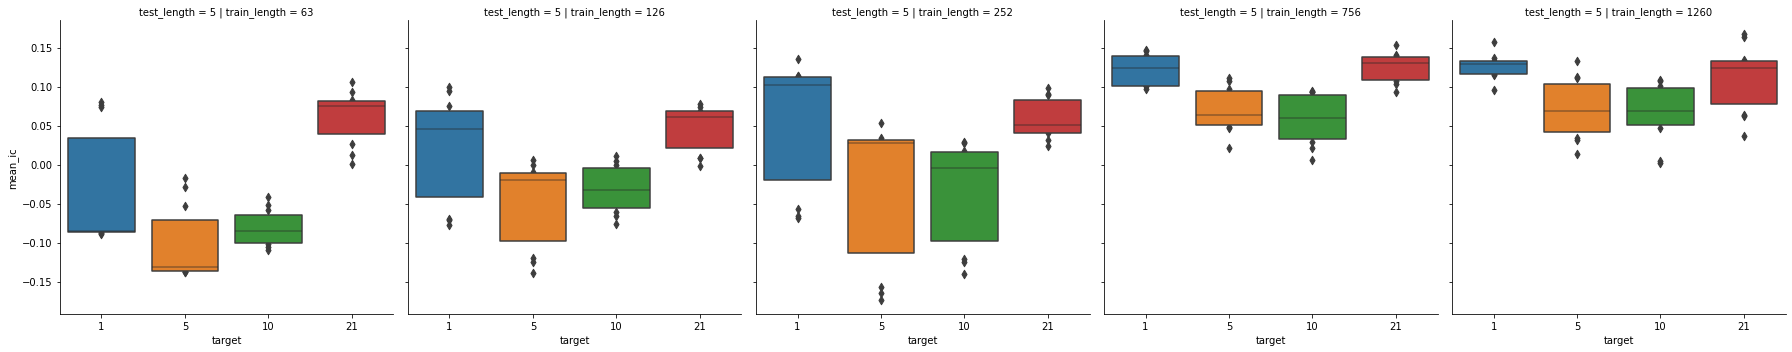

In [36]:
sns.catplot(x='target',
            y='mean_ic',
            col='train_length',
            row='test_length',
            data=cross_val_results[(cross_val_results.test_length == 5)],
            kind='boxen')

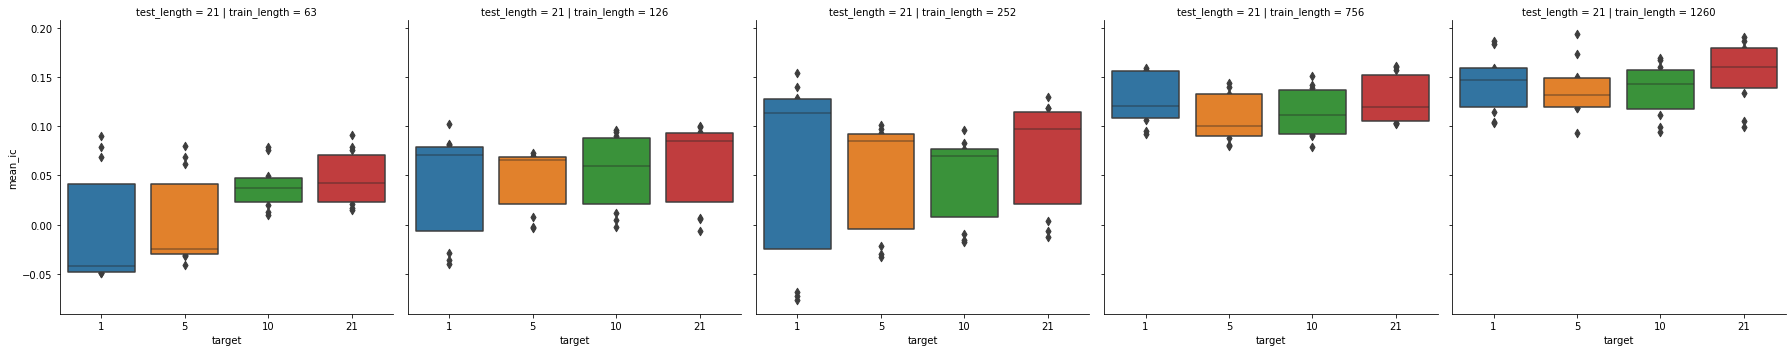

In [37]:
sns.catplot(x='target',
            y='mean_ic',
            col='train_length',
            row='test_length',
            data=cross_val_results[(cross_val_results.test_length == 21)],
            kind='boxen')

As we can see the longer the train periods are the better, the `mean_ic` steadly grows as the train period grows. If
we look also to the test period the previous logic is still valid.

Regarding the standard deviation of the `ic` we can see a great decrease when the test length is longer, while the
train period doesn't seem to affect positively the standard deviation.

In [38]:
hyperparam_res = cross_val_results.groupby(by=['n_estimators', 'max_depth', 'min_samples_leaf'])

hyperparam_res.describe()

mean_ic                                \
                                          count      mean       std       min   
n_estimators max_depth min_samples_leaf                                         
100          5         5                   40.0  0.066938  0.052099 -0.058190   
                       25                  40.0  0.073853  0.072692 -0.133699   
                       100                 40.0  0.018686  0.094137 -0.174116   
             15        5                   40.0  0.067137  0.049123 -0.052001   
                       25                  40.0  0.069342  0.070042 -0.125135   
250          5         100                 40.0  0.023609  0.098867 -0.157054   
             15        5                   40.0  0.070288  0.046894 -0.042150   
                       25                  40.0  0.071032  0.072196 -0.137299   
                       100                 40.0  0.020583  0.097593 -0.164422   

                                                                       \
                                              25%       50%       75%   
n_estimators max_depth min_samples_leaf                                 
100          5         5                 0.039183  0.075439  0.101053   
                       25                0.041800  0.088125  0.129480   
                       100              -0.047659  0.011730  0.101930   
             15        5                 0.045625  0.076540  0.103037   
                       25                0.033184  0.083357  0.122653   
250          5         100              -0.051136  0.010491  0.102668   
             15        5                 0.047507  0.084765  0.099238   
                       25                0.041237  0.079695  0.127785   
                       100              -0.048372  0.005453  0.101662   

                                                  std_ic                      \
                                              max  count      mean       std   
n_estimators max_depth min_samples_leaf                                        
100          5         5                 0.156346   40.0  0.246668  0.067964   
                       25                0.179748   40.0  0.252279  0.076549   
                       100               0.190211   40.0  0.227733  0.090415   
             15        5                 0.153957   40.0  0.245776  0.066883   
                       25                0.156643   40.0  0.252782  0.077793   
250          5         100               0.193948   40.0  0.229805  0.087395   
             15        5                 0.145002   40.0  0.251626  0.066471   
                       25                0.158759   40.0  0.251367  0.075597   
                       100               0.183224   40.0  0.229869  0.090323   

                                                                       \
                                              min       25%       50%   
n_estimators max_depth min_samples_leaf                                 
100          5         5                 0.143428  0.188625  0.246664   
                       25                0.099890  0.188669  0.259033   
                       100               0.090941  0.121915  0.246673   
             15        5                 0.139524  0.185994  0.255743   
                       25                0.110143  0.189705  0.261310   
250          5         100               0.101609  0.123763  0.257245   
             15        5                 0.145401  0.194981  0.253222   
                       25                0.100953  0.188811  0.260109   
                       100               0.092126  0.124280  0.250908   

                                                             
                                              75%       max  
n_estimators max_depth min_samples_leaf                      
100          5         5                 0.313597  0.333802  
                       25                0.323373  0.352929  
                       100               0

By giving a first look to the hyperparameters results, we can see that a larger number of estimators
often gives better `ic`, while is not really clear what kind of impact the others two parameters have.

It seems like that a lower number of sample for each leaf often gives a greater `ic`. Let's see if that it is true by
seeing which combination of parameters gives the highest mean ic.

In [39]:
hyperparam_res.apply(lambda x : x.nlargest(3, 'mean_ic')).drop(['n_estimators', 'max_depth', 'min_samples_leaf'], axis=1)

train_length test_length  \
n_estimators max_depth min_samples_leaf                                
100          5         5                317         1260          21   
                                        327          756           5   
                                        17          1260          21   
                       25               319         1260          21   
                                        339          756          21   
                                        39           756          21   
                       100              310         1260          21   
                                        210         1260          21   
                                        10          1260          21   
             15        5                55           252          21   
                                        35           756          21   
                                        25           756           5   
                       25               334          756          21   
                                        34           756          21   
                                        14          1260          21   
250          5         100              116         1260          21   
                                        16          1260          21   
                                        316         1260          21   
             15        5                23           756           5   
                                        53           252          21   
                                        43           252           5   
                       25               312         1260          21   
                                        32           756          21   
                                        322          756           5   
                       100              11          1260          21   
                                        311         1260          21   
                                        111         1260          21   

                                              mean_ic    std_ic rounds target  
n_estimators max_depth min_samples_leaf                                        
100          5         5                317  0.156346  0.186483     24     21  
                                        327  0.139911  0.322106    100     21  
                                        17   0.132851  0.181271     24      1  
                       25               319  0.179748  0.187960     24     21  
                                        339  0.161495  0.188905     24     21  
                                        39   0.158831  0.194077     24      1  
                       100              310  0.190211  0.215878     24     21  
                                        210  0.160654  0.210699     24     10  
                                        10   0.159081  0.182454     24      1  
             15        5                55   0.153957  0.178335     24      1  
                                        35   0.127312  0.176854     24      1  
                                        25   0.122724  0.281899    100      1  
                       25               334  0.156643  0.191982     24     21  
                                        34   0.156446  0.196219     24      1  
                                        14   0.145568  0.173556     24      1  
250          5         100              116  0.193948  0.221515     24      5  
                                        16   0.186957  0.214005     24      1  
                                        316  0.186653  0.224417     24     21  
             15        5                23   0.145002  0.274168    100      1  
                                        53   0.139733  0.194309     24      1  
                                        43   0.134798  0.290483    100      1  
                       25               312  0.158759  0.217793     24     21  
                                   

From the table above we can see that the combinations which gives the best results are `{'n_estimators': 100, 'max_depth':5, 'min_samples_leaf': 100}` and
`{'n_estimators': 250, 'max_depth':5, 'min_samples_leaf': 100}`.

`n_estimators` parameter doesn't seem to make a big difference in the model, since the result that
we get from the combinations cited above are almost the same, indeed the model with fewer trees performs better
than the one with more trees.


In [40]:
res_target = cross_val_results.groupby(by='target')

res_target.describe()

mean_ic                                                              \
         count      mean       std       min       25%       50%       75%   
target                                                                       
1        100.0  0.066426  0.082785 -0.088416 -0.030319  0.098984  0.127388   
5        100.0  0.031137  0.085663 -0.174116 -0.021445  0.054681  0.093263   
10       100.0  0.037146  0.073816 -0.139836 -0.003876  0.048050  0.092977   
21       100.0  0.087047  0.050165 -0.012699  0.057481  0.091125  0.119924   

                 std_ic                                                    \
             max  count      mean       std       min       25%       50%   
target                                                                      
1       0.186957  100.0  0.232965  0.076905  0.099890  0.174340  0.245204   
5       0.193948  100.0  0.243519  0.074021  0.106925  0.188271  0.245934   
10      0.169536  100.0  0.252171  0.077760  0.108536  0.190572  0.263291   
21      0.190211  100.0  0.248214  0.082655  0.090941  0.184616  0.264477   

                            
             75%       max  
target                      
1       0.301679  0.341082  
5       0.310896  0.363679  
10      0.325020  0.359887  
21      0.323795  0.364217

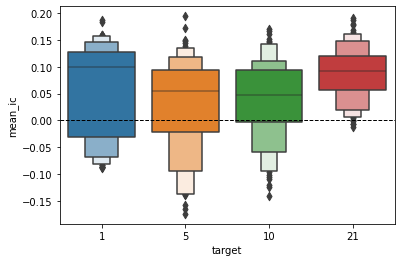

In [41]:
ax = sns.boxenplot(x='target', y='mean_ic', data=cross_val_results)
ax.axhline(0, ls='--', lw=1, c='k')

Now that we've grouped by target (the lookhead of our model) let's see that our previous hypothesis about
the best hyperparameters that we've done before are confirmed.

In [42]:
res_target.apply(lambda x: x.nlargest(3, 'mean_ic')).drop('target', axis=1)

train_length test_length n_estimators max_depth min_samples_leaf  \
target                                                                        
1      16          1260          21          250         5              100   
       11          1260          21          250        15              100   
       10          1260          21          100         5              100   
5      116         1260          21          250         5              100   
       111         1260          21          250        15              100   
       110         1260          21          100         5              100   
10     211         1260          21          250        15              100   
       216         1260          21          250         5              100   
       210         1260          21          100         5              100   
21     310         1260          21          100         5              100   
       316         1260          21          250         5              100   
       319         1260          21          100         5               25   

             mean_ic    std_ic rounds  
target                                 
1      16   0.186957  0.214005     24  
       11   0.183224  0.208548     24  
       10   0.159081  0.182454     24  
5      116  0.193948  0.221515     24  
       111  0.172912  0.223386     24  
       110  0.149622  0.213381     24  
10     211  0.169536  0.224359     24  
       216  0.167021  0.218431     24  
       210  0.160654  0.210699     24  
21     310  0.190211  0.215878     24  
       316  0.186653  0.224417     24  
       319  0.179748  0.187960     24

In [43]:
res_std = cross_val_results[cross_val_results.std_ic != 0.0].groupby(by='target')
res_std.apply(lambda x: x.nsmallest(3, 'std_ic')).drop('target', axis=1)

train_length test_length n_estimators max_depth min_samples_leaf  \
target                                                                        
1      99            63          21          100         5               25   
       98            63          21          250      None               25   
       92            63          21          250        15               25   
5      151          252          21          250        15              100   
       150          252          21          100         5              100   
       156          252          21          250         5              100   
10     296           63          21          250         5              100   
       250          252          21          100         5              100   
       271          126          21          250        15              100   
21     350          252          21          100         5              100   
       391           63          21          250        15              100   
       351          252          21          250        15              100   

             mean_ic    std_ic rounds  
target                                 
1      99  -0.040090  0.099890     24  
       98  -0.049312  0.100781     24  
       92  -0.048031  0.100953     24  
5      151 -0.032405  0.106925     24  
       150 -0.021299  0.115925     24  
       156 -0.029880  0.118468     24  
10     296  0.012607  0.108536     24  
       250 -0.009350  0.112099     24  
       271  0.004410  0.114365     24  
21     350 -0.012699  0.090941     24  
       391  0.015370  0.092126     24  
       351 -0.006404  0.095580     24

From the table above we can see that one of the two best models that we've identified before appears three out of the
four times in the ranking of the first 3 models.

The hyperparameters of the best model are:

`{'n_estimators': 250, 'max_depth':5, 'min_samples_leaf': 100, train_length: 1260, test_length:21}`

Intuitively the parameters that could make the model less prone to overfit the data are: `n_estimators: 100` and
`max_depth: 5`.

In [44]:
base_params = rf_reg.get_params()
model = RandomForestRegressor(base_params)
model_params = {
    'n_estimators': 250,
    'max_depth': 5,
    'max_features': 'log2',
    'min_samples_leaf': 100
}
model = model.set_params(**model_params)
opt_test_length = 21
opt_train_length = 1260

In [45]:
scores = np.array([])

for lookahead in lookaheads:
    n_splits = int(2 * YEAR /  opt_test_length)
    cv = MultipleTimeSeriesCV(
        n_splits=n_splits,
        test_period_length=opt_test_length,
        train_period_length=opt_train_length,
        lookahead=lookahead
    )

    for i, (train_idx, test_idx) in enumerate(cv.split(X)):
        model = model.fit(X.iloc[train_idx], y[f'target_{lookahead}d'].iloc[train_idx])

        y_test = y[f'target_{lookahead}d'].iloc[test_idx]
        y_pred = model.predict(X.iloc[test_idx])
        scores = np.append(scores, rank_correl(y_test, y_pred))
        print(f'Lookhead: {lookahead} | Iteration: {i} | Val score: {scores[-1]}')

Lookhead: 1 | Iteration: 0 | Val score: 0.4090909090909091
Lookhead: 1 | Iteration: 1 | Val score: 0.40389610389610386
Lookhead: 1 | Iteration: 2 | Val score: 0.18571428571428572
Lookhead: 1 | Iteration: 3 | Val score: -0.6935064935064935
Lookhead: 1 | Iteration: 4 | Val score: 0.0038961038961038965
Lookhead: 1 | Iteration: 5 | Val score: 0.08571428571428572
Lookhead: 1 | Iteration: 6 | Val score: -0.00909090909090909
Lookhead: 1 | Iteration: 7 | Val score: 0.24285714285714283
Lookhead: 1 | Iteration: 8 | Val score: 0.10519480519480517
Lookhead: 1 | Iteration: 9 | Val score: 0.051948051948051945
Lookhead: 1 | Iteration: 10 | Val score: -0.14155844155844155
Lookhead: 1 | Iteration: 11 | Val score: 0.02727272727272727
Lookhead: 1 | Iteration: 12 | Val score: 0.49870129870129876
Lookhead: 1 | Iteration: 13 | Val score: 0.174025974025974
Lookhead: 1 | Iteration: 14 | Val score: 0.24675324675324672
Lookhead: 1 | Iteration: 15 | Val score: -0.17662337662337665
Lookhead: 1 | Iteration: 16 | V

In [46]:
import pickle

save_model = True
load_model = False
pkl_filename = "./fine_tune_rf.pkl"

if save_model:
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)

if load_model:
    with open(pkl_filename, 'rb') as file:
        model = pickle.load(file)

## Evaluate the Best Model

In [47]:
y_test = data.filter(like='target').loc['2019': '2021']

In [48]:
print(rank_correl(model.predict(X_test.iloc[-30:]), y_test.target_1d.values[-30:]))

-0.10658965553308332


In [49]:
print(rank_correl(model.predict(X_test.iloc[-30:]), y_test.target_5d.values[-30:]))

0.07804681890497733


In [50]:
print(rank_correl(model.predict(X_test.iloc[-30:]), y_test.target_10d.values[-30:]))

0.37908454896703275


In [51]:
print(rank_correl(model.predict(X_test.iloc[-30:]), y_test.target_21d.values[-30:]))


0.4245746948430766


## Parameters importance

Let's now explore what are the most important features that our model uses to make his predictions.

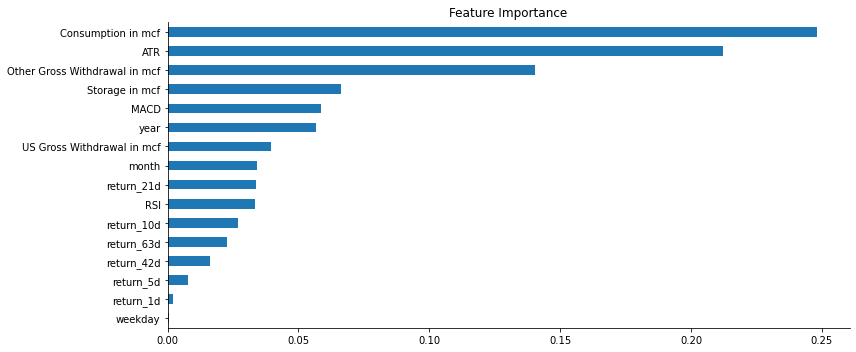

In [52]:

fig, ax = plt.subplots(figsize=(12,5))
(pd.Series(model.feature_importances_, index=X.columns)
 .sort_values(ascending=False)
 .iloc[:20]
 .sort_values()
 .plot.barh(ax=ax, title='Feature Importance'))

sns.despine()

fig.tight_layout();

Using the builtin `features_importances_` attribute from our model we can see that the most impactful params are:

- ATR
- NG consumption
- Other States Gross Withdrawal
- US Gross Withdrawal
- year
- MACD

To have a more holistic view of the importance of the features, we can use two others functions provided by
sklearn: `permutation_importance` and `partial_dependence`.

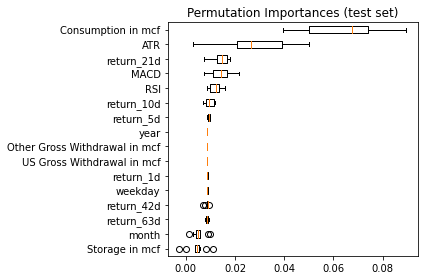

In [53]:
from sklearn.inspection import permutation_importance, partial_dependence

result = permutation_importance(model, X_test, y_test.target_21d, n_repeats=10, n_jobs=-1, max_samples=0.3)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

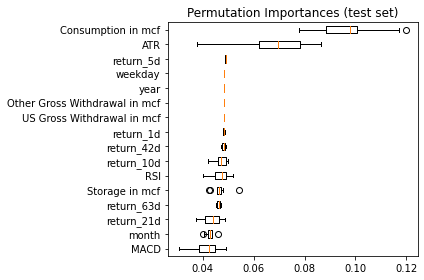

In [54]:
result = permutation_importance(model, X_test, y_test.target_21d, n_repeats=10, n_jobs=-1, max_samples=0.3)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Partial dependence

Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest,
marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.

### Partial dependence between the ATR and MACD

What is really significant in the image below is the gap in the partial dependence values when the approaches values
between 0.16 and 0.14.

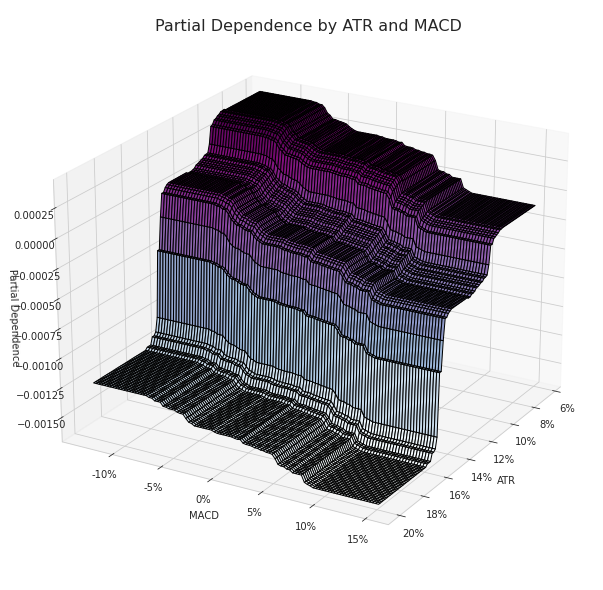

In [55]:
sns.set_style('whitegrid')
targets = ['ATR', 'MACD']
pdp, axes = partial_dependence(estimator=model,
                               features=targets,
                               X=X_test,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('ATR')
ax.set_ylabel('MACD')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# fig.colorbar(surface)
fig.suptitle('Partial Dependence by ATR and MACD', fontsize=16)
fig.tight_layout()

### Partial dependence between the Consumption and Storage

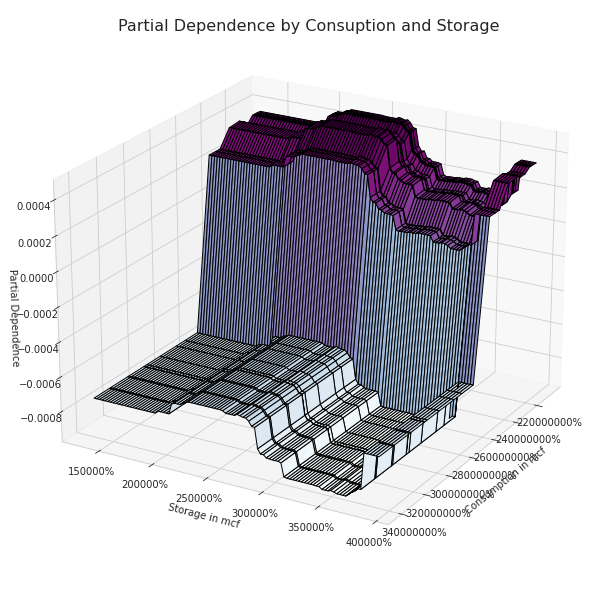

In [56]:
sns.set_style('whitegrid')
targets = ['Consumption in mcf', 'Storage in mcf']
pdp, axes = partial_dependence(estimator=model,
                               features=targets,
                               X=X_test,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('Consumption in mcf')
ax.set_ylabel('Storage in mcf')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# fig.colorbar(surface)
fig.suptitle('Partial Dependence by Consuption and Storage', fontsize=16)
fig.tight_layout()

### Partial Dependence between 10 and 21 return days

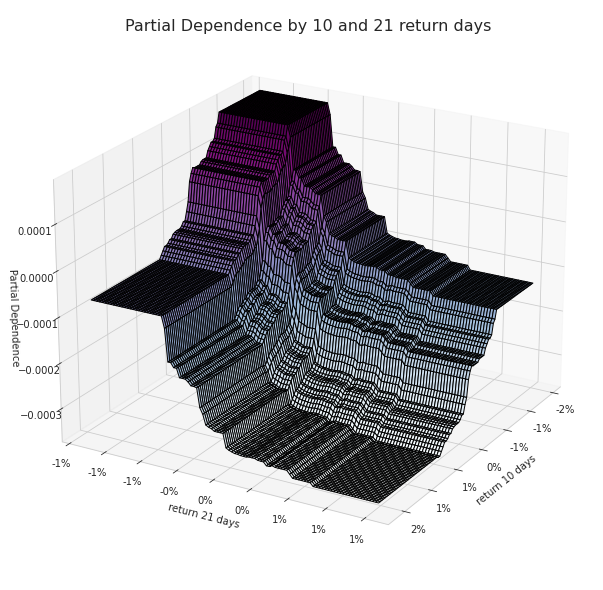

In [57]:
sns.set_style('whitegrid')
targets = ['return_10d', 'return_21d']
pdp, axes = partial_dependence(estimator=model,
                               features=targets,
                               X=X_test,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
ax.plot_surface(XX, YY, Z,
                    rstride=1,
                    cstride=1,
                    cmap=plt.cm.BuPu,
                    edgecolor='k')
ax.set_xlabel('return 10 days')
ax.set_ylabel('return 21 days')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

fig.suptitle('Partial Dependence by 10 and 21 return days', fontsize=16)
fig.tight_layout()

### Partial Dependence between 1 and 5 return days


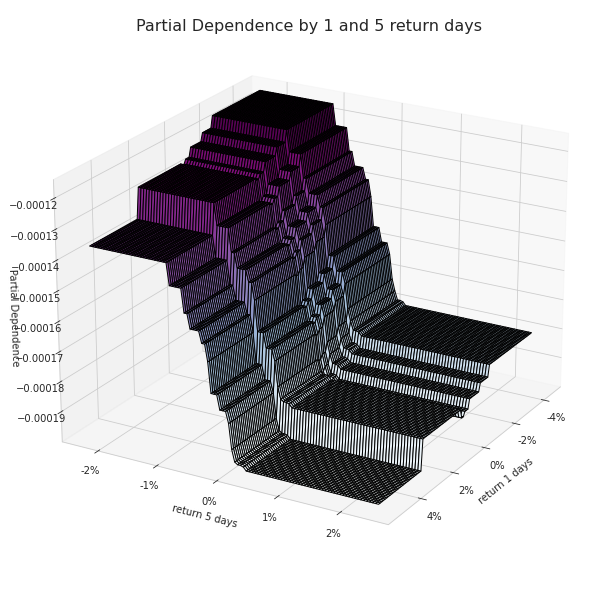

In [58]:
sns.set_style('whitegrid')
targets = ['return_1d', 'return_5d']
pdp, axes = partial_dependence(estimator=model,
                               features=targets,
                               X=X_test,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
ax.plot_surface(XX, YY, Z,
                    rstride=1,
                    cstride=1,
                    cmap=plt.cm.BuPu,
                    edgecolor='k')
ax.set_xlabel('return 1 days')
ax.set_ylabel('return 5 days')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

fig.suptitle('Partial Dependence by 1 and 5 return days', fontsize=16)
fig.tight_layout()

### Partial Dependence between NG Consuption and ATR

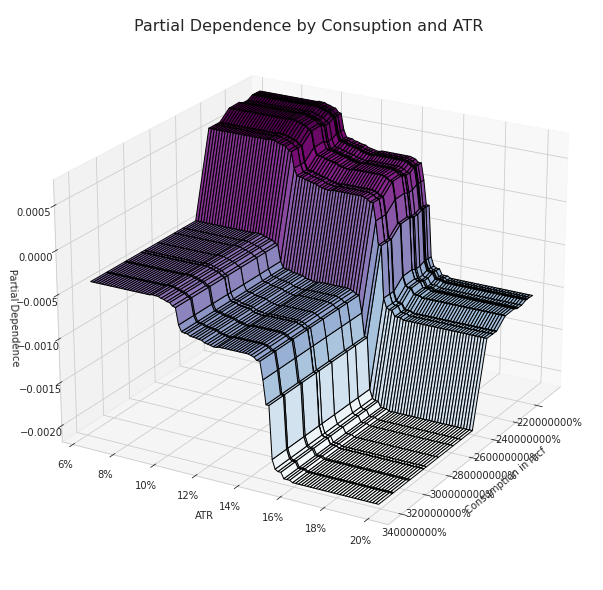

In [59]:
sns.set_style('whitegrid')
targets = ['Consumption in mcf', 'ATR']
pdp, axes = partial_dependence(estimator=model,
                               features=targets,
                               X=X_test,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('Consumption in mcf')
ax.set_ylabel('ATR')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

fig.suptitle('Partial Dependence by Consuption and ATR', fontsize=16)
fig.tight_layout()

Comparing the two most important features identified before (the ATR and the Consumption) we can clearly
we can see not only higher partial dependence values but also a well-defined pattern.
As the ATR and the Consuption are approaching lower values the partial dependence grows, the opposite happens
when the opposite conditions occur.

## Shap Values

Shapley values originated in game theory as a technique for assigning a value to each player in a collaborative game
that reflects their contribution to the team's success. SHAP values are an adaptation of the game theory concept to
tree-based models and are calculated for each feature and each sample. They measure how a feature contributes to the
model output for a given observation. For this reason, SHAP values provide differentiated insights into how the impact
of a feature varies across samples, which is important given the role of interaction effects in these nonlinear models.



Shapley values are computed by introducing each feature, one at a time, into a conditional expectation function of the
model’s output, $$f_x(S) = \mathbb{E}[f(X) | do(X_s = x_s)]$$, and attributing the change produced at each step to the feature that was introduced; then averaging this process over all possible feature orderings.

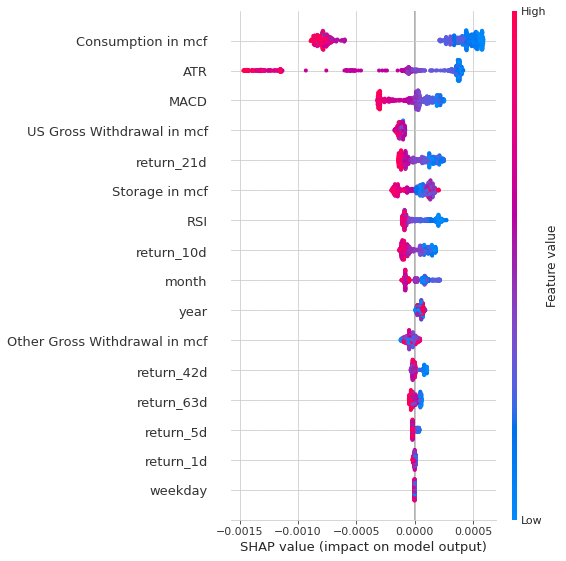

In [60]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X=X_test)

shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()

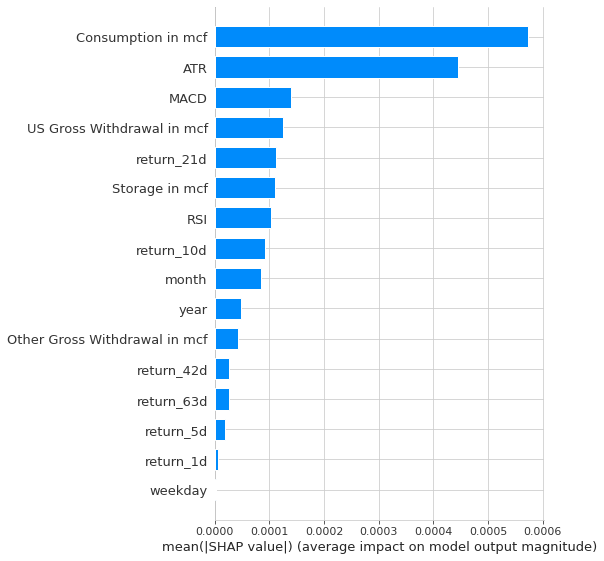

In [61]:

shap.summary_plot(shap_values, X_test, plot_type="bar",show=False)
plt.tight_layout()

The Shap values that we are seeing in the two images are confirming the most important features that
we've identified before, which are: ATR, Consumption, Other Gross Withdrawal, US Gross Withdrawal, year and
the MACD.

What Shap values are telling us more is how each feature is positively/negatively impact the output. We can see from
the first picture that:

- lower values of ATR usually lead to better returns, while when the ATR is higher the opposite tend to happend
- we can say the same thing about the Consumption
- earlier months often yield to worse result
- lower values of MACD are positively correlated to higher model output values, like the atr
- US Gross Withdrawal Values that have highly deviated from the mean tend to yield to positive returns, while closer values to mean often yield negative returns

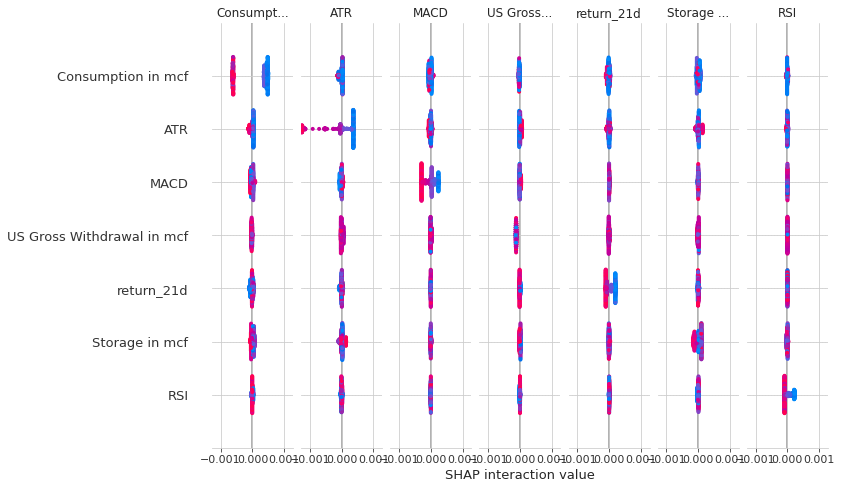

In [62]:
shap_interaction_values = explainer.shap_interaction_values(X_test)

shap.summary_plot(shap_interaction_values, X_test)

# Backtesting

Now that we trained and evaluated the most important features of our model let's use it in a trading strategy on the natural gas
futures.

The strategy that I'm going to implement is the following:

Since the model has been trained to predict the return of the next `n` days I'm going to use a window of predictions (for instance a 10-day window) and I'm going to look for a peak positive or negative in that window of predictions. Once I've identified the peak, if the peak is positive I'm going to submit a buy order, while if the peak is negative I'm going to submit a sell order.

So, what I'm doing is to leverage the forecast of the model for the next period to submit an order.

The money management and risk management rule that the startegy is going to use are the following:

- **Money management**: 5% of the total equity per trade
- **Risk management**: a trailing stop that is looking at the low of the third previous day and subtact the current atr multiplied by 1.5

Let's see how it works in practice.


In [63]:
backtest_data = data.loc['2019':'2021']

In [64]:
import math

from scipy.signal import find_peaks

from backtesting import Backtest, Strategy

import tulipy as tu

Loading BokehJS ...

In [65]:
def return_indicator(values, data_len: int):
    a = np.empty((data_len - len(values),))
    a[:] = np.nan
    return np.concatenate([a, values])

def get_atr(data: pd.DataFrame, n: int):
    atr = tu.atr(data.High, data.Low, data.Close, n)
    return return_indicator(atr, len(data))

In [66]:
class RFModelStrategy(Strategy):
    risk = 5 # 5% of the total amount per trade
    pred_len = 18
    atr_stop_multiplier = 1.5
    trailingATRLen = 5


    def init(self):
        super(RFModelStrategy, self).init()
        self.lookback = 3
        self.pointvalue = 10

        self.model = model
        self.atr = self.I(get_atr, self.data, 14, plot=False)
        self.trailingAtr = self.I(get_atr, self.data, self.trailingATRLen, plot=False)
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast', color='red')

    def get_signal(self, predictions):
        if np.sum(predictions < 0, axis=0) / self.pred_len > 0.75:
            neg_peaks, _ = find_peaks(-predictions, width=2)

            if len(neg_peaks) != 0:
                return 'Sell'

        elif np.sum(predictions > 0, axis=0) / self.pred_len > 0.75:
            peaks, _ = find_peaks(predictions, width=2)

            if len(peaks) != 0:
                return 'Buy'

        return 'No signal'

    def next(self):
        X, _ = get_X_y(self.data.df)
        predictions = self.model.predict(X[-self.pred_len:])

        self.forecasts[-1] = self.model.predict(X[-2:])[0]

        if len(self.trades) == 0:
            signal = self.get_signal(predictions)

            if signal == 'Sell':
                self.sell(size=self.get_position_size())
            elif signal == 'Buy':
                self.buy(size=self.get_position_size())
        else:

            signal = self.get_signal(predictions)

            if self.trades[0].is_long:
                if signal == 'Sell' or \
                        self.data.Low[-1] <= self.get_trailing_stop(long=True):
                    self.position.close()
                    if signal == 'Sell':
                        self.sell(size=self.get_position_size())
            else:
                if signal == 'Buy' or \
                        self.data.High[-1] >= self.get_trailing_stop(long=False):
                    self.position.close()
                    if signal == 'Buy':
                        self.buy(size=self.get_position_size())

    def get_position_size(self):
        return math.floor((self.risk / 100 * self.equity) / (self.atr * self.pointvalue))

    def get_trailing_stop(self, long: bool):
        if long:
            return np.max(self.data.Low[-self.lookback:]) - self.trailingAtr[-1] * self.atr_stop_multiplier
        else:
            return np.min(self.data.High[-self.lookback:]) + self.trailingAtr[-1] * self.atr_stop_multiplier

In [67]:
bt = Backtest(backtest_data, RFModelStrategy, cash=250_000, trade_on_close=True, commission=0.02)

stats = bt.run()

stats

Start                     2019-01-02 00:00:00
End                       2021-08-30 00:00:00
Duration                    971 days 00:00:00
Exposure Time [%]                   86.885246
Equity Final [$]                 265779.51708
Equity Peak [$]                   273257.4474
Return [%]                           6.311807
Buy & Hold Return [%]               45.537525
Return (Ann.) [%]                    2.325274
Volatility (Ann.) [%]                4.850827
Sharpe Ratio                         0.479356
Sortino Ratio                        0.710287
Calmar Ratio                         0.361023
Max. Drawdown [%]                   -6.440789
Avg. Drawdown [%]                   -1.015387
Max. Drawdown Duration      559 days 00:00:00
Avg. Drawdown Duration       44 days 00:00:00
# Trades                                   22
Win Rate [%]                        54.545455
Best Trade [%]                      28.220627
Worst Trade [%]                    -27.783283
Avg. Trade [%]                    

In [68]:
bt.plot(filename='./tree_regressor_backtesting.html')


Row(id='1461', ...)

![](../imgs/bokeh_plot_1.png)

![](../imgs/bokeh_plot_5.png)

![](../imgs/bokeh_plot_2.png)

![](../imgs/bokeh_plot_3.png)

![](../imgs/bokeh_plot_4.png)

# References

- [NHANES I Survival Model](https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html#NHANES-I-Survival-Model)
- [Long-Short Strategy, Part 4: How to interpret GBM results](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/12_gradient_boosting_machines/07_model_interpretation.ipynb)